# Modelo predictivo del bienestar estudiantil
Vanessa Rodríguez Horcajo-TFM

En este notebook se recogen todas las pruebas ejecutadas para la implementación de un  modelo predictivo del grado de bienestar físico y anímico de los estudiantes en base a un conjunto de características físicas y ambientales, tanto internas como externas, del aula.

Partimos del conjunto de datos obtenido de la agregación de los datos ambientales interiores del aula recogidos por las motas sesoras, los datos ambientales exteriores del aula recogidos por la estación meteorológoca más cercana a la ETSISI y los datos procedentes de los cuestionarios de bienestar. Todo este procesamiento y agregación de datos se encuentra contenido en en notebook Data_Union_TFM.


In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import sklearn.compose
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pickle

# Tratamiento de datos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Regressors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Métricas clasificación
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Métricas regresión
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Ploteos
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


## Carga de los datos

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
r_df = "/content/drive/My Drive/TFM/Datos_Finales/Final_Data.csv"
df = pd.read_csv(r_df, sep=';', encoding='utf-8')
df.head(1)

,Fecha,HIC,HFC,Aula,Grupo,Orientacion,Grados,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,27.42,28.434,28.986,721.85,805.117,751.74,738.708,746.863,764.373,35.835,36.647,36.268,36.185,36.234,36.42


In [ ]:
df.columns

Index(['Fecha', 'HIC', 'HFC', 'Aula', 'Grupo', 'Orientacion', 'Grados', 'Mota',
       'Puesto', 'Luces_apagadas', 'Cortinas_abiertas', 'Luminosidad', 'Ruido',
       'AACC_enc', 'Calefacción_enc', 'Ventanas_abiertas', 'Temperatura',
       'Ambiente_cargado', 'Ocupación_aula', 'Comodidad_aula', 'E_anímico',
       'Sentimiento_ánimo', 'E_físico', 'Sentimiento_físico', 'TempEXTHIC',
       'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED', 'HumEXTHFC',
       'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'TempINTQ1', 'TempINTQ2',
       'TempINTQ3', 'LumINTMIN', 'LumINTMAX', 'LumINTMED', 'LumINTQ1',
       'LumINTQ2', 'LumINTQ3', 'HumINTMIN', 'HumINTMAX', 'HumINTMED',
       'HumINTQ1', 'HumINTQ2', 'HumINTQ3'],
      dtype='object')

En este conjunto de datos, cada una de las muestras se corresponde con un cuestionario y contiene la siguiente información:

1. Fecha en la que se rellena el cuestionario.
2. Hora de inicio de la clase.
3. Hora de finalización de la clase.
4. Aula a la que pertenece el alumno que rellena el cuestionario.
5. Grupo al que pertenece el alumno que rellena el cuestionario.
6. Orientación cardinal del aula.
7. Grados de orientación del aula.
8. Mota sensora más cercana según el puesto del alumno.
9. Puesto en el aula donde se encuentra sentado el alumno.
10. Si están las luces apagadas. Respuesta binaria Si/No.
11. Grado de apertura de las cortinas del aula según una escala de Likert de 1 a 5, siendo 5 todas las cortinas abiertas y 1 todas las cortinas cerradas.
12. Adecuación de la luminosidad durante la clase según una escala de Likert de 1 a 5, siendo 5 una luminosidad totalmente adecuada y 1 una luminosidad nada adecuada.
13. Nivel de ruido durante la clase según una escala de Likert de 1 a 5, siendo 5 un bajo nivel de ruido y 1 un nivel alto de ruido.
14. Si está el aire acondicionado encendido. Respuesta binaria Si/No. En caso afirmativo, debe indicarse los grados si es posible su identificación.
15. Si está la calefacción encendida. Respuesta binaria Si/No.
16. Si están las ventanas abiertas. Respuesta ternaria Parcialmente/Si/No.
17. Adecuación de la temperatura durante la clase según una escala de Likert de 1 a 5, siendo 5 una temperatura totalmente adecuada y 1 una temperatura nada adecuada.
18. Densidad y carga del ambiente según una escala de Likert de 1 a 5, siendo 5 un ambiente nada cargado y 1 un ambiente muy cargado.
19. Grado de ocupación del aula según una escala de Likert de 1 a 5, siendo 5 un aula llena y 1 un aula vacía.
20. Grado de comodidad del aula durante la clase según una escala de Likert de 1 a 5, siendo 5 totalmente confortable y 1 no confortable.
21. Opinión de la afirmación *La docencia impartida en la clase me ha parecido buena* según una escala de Likert totalmente de acuerdo, de acuerdo, normal, en desacuerdo y totalmente en desacuerdo.
22. Opinión de la afirmación *Mi estado ANÍMICO durante la clase ha sido bueno* según una escala de Likert totalmente de acuerdo, de acuerdo, ni de acuerdo ni en desacuerdo, en desacuerdo y totalmente en desacuerdo.
23. Emociones identificadas en su estado anímico: eufórico, motivado, contento, normal, cansado, con ansiedad, agobiado, estresado, triste, aburrido o dormido. Pregunta de respuesta múltiple.
24. Opinión de la afirmación *Mi estado FÍSICO durante la clase ha sido bueno* según una escala de Likert totalmente de acuerdo, de acuerdo, ni de acuerdo ni en desacuerdo, en desacuerdo y totalmente en desacuerdo.
25. Emociones identificadas en su estado físico: enérgico, normal, agotado, enfermo, con hambre o sed, con dolor de cuello, con dolor de cabeza, con dolor de espalda o con sueño. Pregunta de respuesta múltiple.
26. Temperatura externa a la hora del inicio de la clase.
27. Temperatura externa a la hora media de la clase.
28. Temperatura externa a la hora del final de la clase.
26. Humedad externa a la hora del inicio de la clase.
27. Humedad externa a la hora media de la clase.
28. Humedad externa a la hora del final de la clase.
29. Temperatura interna mínima entre las horas de unicio y finalización de la clase.
30. Temperatura interna máxima entre las horas de unicio y finalización de la clase.
31. Temperatura interna media entre las horas de unicio y finalización de la clase.
32. Temperatura interna primer quartil entre las horas de unicio y finalización de la clase.
33. Temperatura interna segundo cuartil entre las horas de unicio y finalización de la clase.
34. Temperatura interna tercer cuartil entre las horas de unicio y finalización de la clase.
35. Humedad interna mínima entre las horas de unicio y finalización de la clase.
36. Temperatura interna máxima entre las horas de unicio y finalización de la clase.
37. Humedad interna media entre las horas de unicio y finalización de la clase.
38. Humedad interna primer quartil entre las horas de unicio y finalización de la clase.
39. Humedad interna segundo cuartil entre las horas de unicio y finalización de la clase.
40. Humedad interna tercer cuartil entre las horas de unicio y finalización de la clase.
35. Luminosidad interna mínima entre las horas de unicio y finalización de la clase.
36. Luminosidad interna máxima entre las horas de unicio y finalización de la clase.
37. Luminosidad interna media entre las horas de unicio y finalización de la clase.
38. Luminosidad interna primer quartil entre las horas de unicio y finalización de la clase.
39. Luminosidad interna segundo cuartil entre las horas de unicio y finalización de la clase.
40. Luminosidad interna tercer cuartil entre las horas de unicio y finalización de la clase.

Es decir, las columnas 1-9 representan características generales del cuestionario en sí; las columnas 10,11,14-16,19 representan el estado físisco del aula en el periodo de tiempo donde se rellena el cuestionario; las columnas 12,13,17,18,20-25 representan las percepciones de los estudiantes ante distintas variales físicas y ambientales del aula; las columnas 26-28 representan las condiciones climatológicas externas del aula en el periodo de tiempo donde se rellena el cuestionario; y las columnas 27-40 representan las condiciones climatológicas internas del aula en el periodo de tiempo donde se rellena el cuestionario.

Una vez contextualizados los datos, es posible comenzar a diseñar el modelo predictivo de bienestar estudiantil.


## Preperación de los datos

Recordemos que el objetivo final consiste en predecir el grado de bienestar físico y anímico de los estudiantes en base a un conjunto de características físicas y ambientales, tanto internas como externas, del aula. De esta manera, las columnas objetivo se corresponden con las columnas 22 y 24.


In [ ]:
df.E_físico.unique()

array(['De acuerdo', 'Totalmente de acuerdo',
       'Ni de acuerdo ni en desacuerdo', 'En desacuerdo',
       'Totalmente en desacuerdo'], dtype=object)

In [ ]:
df.E_anímico.unique()

array(['Totalmente de acuerdo', 'De acuerdo', 'En desacuerdo',
       'Ni de acuerdo ni en desacuerdo', 'Totalmente en desacuerdo'],
      dtype=object)

Actualmente, estas columnas contienen datos de tipo texto que se corresponden con una escala de Likert de 5 niveles: totalmente en desacuerdo, en desacuerdo, ni de acuerdo ni en desacuerdo, de acuerdo y totalmente de acuerdo. La primera transformación que vamos a realizar será el mapeo de estos cinco niveles en la escala a distintas clases, de tal manera que cada clase represente un grado de conformidad con la afirmación *Mi estado ANÍMICO/FÍSICO durante la clase ha sido bueno* y por tanto un grado de bienestar del alumno. Es decir, se va a transformar la escala Likert anterior a una escala Likert del grado de bienestar ANÍMICO/FÍSICO del estudiante. Así:

* Totalmente en desacuerdo -> Nivel en la escala de bienestar anímico/físico de 1.
* En desacuerdo -> Nivel en la escala de bienestar anímico/físico de 2.
* Ni de acuerdo ni en desacuerdo -> Nivel en la escala de bienestar anímico/físico de 3.
* De acuerdo -> Nivel en la escala de bienestar anímico/físico de 1.
* Totalmente de acuerdo -> Nivel en la escala de bienestar anímico/físico de 5.

Función `asignar_grado_bienestar`: función encargada de mapear los valores presentes en las columnas objetivo con la nueva escala Likert de grado de bienestar del alumno.

In [ ]:
def asignar_grado_bienestar(valor):
  mapeo_grado_bienestar = {'Totalmente en desacuerdo': 1,
                           'En desacuerdo': 2,
                           'Ni de acuerdo ni en desacuerdo': 3,
                           'De acuerdo': 4,
                           'Totalmente de acuerdo': 5
                           }

  return mapeo_grado_bienestar[valor]

In [ ]:
df['G_B_A'] = df['E_anímico'].apply(asignar_grado_bienestar)
df['G_B_F'] = df['E_físico'].apply(asignar_grado_bienestar)

In [ ]:
df.head(3)

,Fecha,HIC,HFC,Aula,Grupo,Orientacion,Grados,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3,G_B_A,G_B_F
0,08/11/2023,09:00:00,11:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,27.420,28.434,28.986,721.850,805.117,751.740,738.708,746.863,764.373,35.835,36.647,36.268,36.185,36.234,36.420,5,4
1,08/11/2023,11:00:00,13:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,29.561,29.900,30.224,740.951,928.242,861.458,836.731,864.369,899.354,35.545,36.440,35.972,35.736,35.995,36.203,5,4
2,08/11/2023,13:00:00,15:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.020,30.622,30.389,30.610,30.857,722.115,1268.535,833.763,745.438,767.356,810.547,34.984,36.321,35.726,35.408,35.756,36.055,5,4


Para facilitar la representación de los datos relacionados con la franja horaria a la que pertenece cada cuestionario, se va a crear una nueva columna que contenga la franja horaria correspondiente según lo siguiente:

* 9h-11h -> Franja horaria 1.
* 11h-13h -> Franja horaria 2.
* 13h-15h -> Franja horaria 3.
* 15h-17h -> Franja horaria 4.
* 17h-19h -> Franja horaria 5.
* 19h-21h -> Franja horaria 6.

In [ ]:
def asignar_fh(valor):
  mapeo_fh = {'09:00:00': 1,
              '11:00:00': 2,
              '13:00:00': 3,
              '15:00:00': 4,
              '17:00:00': 5,
              '19:00:00': 6
                           }

  return mapeo_fh[valor]

In [ ]:
df['FH'] = df['HIC'].apply(asignar_fh)

In [ ]:
df.head(3)

,Fecha,HIC,HFC,Aula,Grupo,Orientacion,Grados,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3,G_B_A,G_B_F,FH
0,08/11/2023,09:00:00,11:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,27.420,28.434,28.986,721.850,805.117,751.740,738.708,746.863,764.373,35.835,36.647,36.268,36.185,36.234,36.420,5,4,1
1,08/11/2023,11:00:00,13:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,29.561,29.900,30.224,740.951,928.242,861.458,836.731,864.369,899.354,35.545,36.440,35.972,35.736,35.995,36.203,5,4,2
2,08/11/2023,13:00:00,15:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.020,30.622,30.389,30.610,30.857,722.115,1268.535,833.763,745.438,767.356,810.547,34.984,36.321,35.726,35.408,35.756,36.055,5,4,3


Puesto que la predicción del grado de bienestar se pretende realizar en base a un conjunto de características físicas y ambientales, tanto internas como externas, del aula, en segundo lugar se eliminan las columnas que no se van a emplear en la predicción.

In [ ]:
df.columns

Index(['Fecha', 'HIC', 'HFC', 'Aula', 'Grupo', 'Orientacion', 'Grados', 'Mota',
       'Puesto', 'Luces_apagadas', 'Cortinas_abiertas', 'Luminosidad', 'Ruido',
       'AACC_enc', 'Calefacción_enc', 'Ventanas_abiertas', 'Temperatura',
       'Ambiente_cargado', 'Ocupación_aula', 'Comodidad_aula', 'E_anímico',
       'Sentimiento_ánimo', 'E_físico', 'Sentimiento_físico', 'TempEXTHIC',
       'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED', 'HumEXTHFC',
       'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'TempINTQ1', 'TempINTQ2',
       'TempINTQ3', 'LumINTMIN', 'LumINTMAX', 'LumINTMED', 'LumINTQ1',
       'LumINTQ2', 'LumINTQ3', 'HumINTMIN', 'HumINTMAX', 'HumINTMED',
       'HumINTQ1', 'HumINTQ2', 'HumINTQ3', 'G_B_A', 'G_B_F', 'FH'],
      dtype='object')

In [ ]:
columnas_a_eliminar = ['Fecha', 'Grupo', 'Grados', 'HIC', 'HFC', 'Aula', 'Mota',
       'Puesto', 'Luminosidad', 'Ruido','Temperatura',
       'Ambiente_cargado', 'Comodidad_aula', 'E_anímico',
       'Sentimiento_ánimo', 'E_físico', 'Sentimiento_físico','TempINTQ1', 'TempINTQ2',
       'TempINTQ3','LumINTQ1','LumINTQ2', 'LumINTQ3','HumINTQ1', 'HumINTQ2', 'HumINTQ3']
df.drop(columnas_a_eliminar, axis=1, inplace=True)

In [ ]:
df.columns

Index(['Orientacion', 'Luces_apagadas', 'Cortinas_abiertas', 'AACC_enc',
       'Calefacción_enc', 'Ventanas_abiertas', 'Ocupación_aula', 'TempEXTHIC',
       'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED', 'HumEXTHFC',
       'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'LumINTMIN', 'LumINTMAX',
       'LumINTMED', 'HumINTMIN', 'HumINTMAX', 'HumINTMED', 'G_B_A', 'G_B_F',
       'FH'],
      dtype='object')

Tal y como puede observarse, en el DataFrame solo quedan presentes las variables relacionadas con las características físicas y ambientales internas y externas del aula y las dos variables del grado de bienestar físico y anímico a predecir.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Orientacion        959 non-null    object 
 1   Luces_apagadas     959 non-null    object 
 2   Cortinas_abiertas  959 non-null    float64
 3   AACC_enc           959 non-null    object 
 4   Calefacción_enc    959 non-null    object 
 5   Ventanas_abiertas  959 non-null    object 
 6   Ocupación_aula     959 non-null    int64  
 7   TempEXTHIC         959 non-null    float64
 8   TempEXTMED         959 non-null    float64
 9   TempEXTHFC         959 non-null    float64
 10  HumEXTHIC          959 non-null    float64
 11  HumEXTMED          959 non-null    float64
 12  HumEXTHFC          959 non-null    float64
 13  TempINTMIN         959 non-null    float64
 14  TempINTMAX         959 non-null    float64
 15  TempINTMED         959 non-null    float64
 16  LumINTMIN          959 non

Como podemos observar, existen columnas que no son de tipo numérico. Los modelos predictivos trabajan con variables númericas o con la representación numérica de las variables catagóricas en su defecto. Veamos que contienen las columnas que no son numéricas.

In [ ]:
df.Orientacion.unique()

array(['O', 'SE'], dtype=object)

In [ ]:
df.Luces_apagadas.unique()

array(['No', 'Sí'], dtype=object)

In [ ]:
df.AACC_enc.unique()

array(['No', 'Sí'], dtype=object)

In [ ]:
df.Calefacción_enc.unique()

array(['No', 'Sí'], dtype=object)

In [ ]:
df.Ventanas_abiertas.unique()

array(['Parcialmente', 'Sí', 'No'], dtype=object)

Todas las variables que no son de tipo numérico son de tipo categórico. Para representar estos datos de forma numérica, mapearemos cada valor único presente en la columna con una clase.

Para procesar estas columnas que contienen valores categóricos, se podría emplear Label Encoder, de tal manera que mapease cada valor presente en una columna con una clase, similar al procesamiento que se ha realizado sobre las columnas de estado físico y anímico manualmente. Sin embargo, el objetivo final consiste en que los directores de la escuela puedan hacer inferencia con el modelo para poder predecir el grado de bienestar de los estudiantes. Al igual que los datos de entrenamiento y test empleados para la implementación y evaluación del modelo, los datos empleados en la inferencia tienen que preprocesarse de la misma manera. Puesto que no existe la forma de decirle a Label encoder qué valor se mapea con qué clase, y necesitamos llevar este control para poder trasformar los datos de inferencia, este mapeo se realizará de nuevo manualmente.

In [ ]:
def asignar_si_no_p(valor):
  if valor == 'Sí':
    return 1
  elif valor == 'No':
    return 0
  else: return 2

In [ ]:
def asignar_punto_cardinal(valor):
  mapeo_grado_bienestar = {'N': 1,
                           'S': 2,
                           'E': 3,
                           'O': 4,
                           'NE': 5,
                           'SE': 6,
                           'NO': 7,
                           'SO': 8,
                           }
  return mapeo_grado_bienestar[valor]

In [ ]:
df['Luces_apagadas'] = df['Luces_apagadas'].apply(asignar_si_no_p)
df['AACC_enc'] = df['AACC_enc'].apply(asignar_si_no_p)
df['Calefacción_enc'] = df['Calefacción_enc'].apply(asignar_si_no_p)
df['Ventanas_abiertas'] = df['Ventanas_abiertas'].apply(asignar_si_no_p)
df['Orientacion'] = df['Orientacion'].apply(asignar_punto_cardinal)

In [ ]:
df.head(5)

,Orientacion,Luces_apagadas,Cortinas_abiertas,AACC_enc,Calefacción_enc,Ventanas_abiertas,Ocupación_aula,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,LumINTMIN,LumINTMAX,LumINTMED,HumINTMIN,HumINTMAX,HumINTMED,G_B_A,G_B_F,FH
0,4,0,5.0,0,0,2,2,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,721.850,805.117,751.740,35.835,36.647,36.268,5,4,1
1,4,0,5.0,0,0,2,2,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,740.951,928.242,861.458,35.545,36.440,35.972,5,4,2
2,4,0,5.0,0,0,2,2,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.020,30.622,722.115,1268.535,833.763,34.984,36.321,35.726,5,4,3
3,4,0,5.0,0,0,2,2,6.0,7.0,8.7,69.0,67.0,62.0,26.964,28.518,27.840,793.625,864.255,837.203,33.129,33.733,33.401,4,4,1
4,4,0,5.0,0,0,2,2,8.7,9.7,9.9,62.0,60.0,62.0,28.518,29.629,29.142,760.550,864.401,802.253,33.345,34.564,34.077,4,4,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Orientacion        959 non-null    int64  
 1   Luces_apagadas     959 non-null    int64  
 2   Cortinas_abiertas  959 non-null    float64
 3   AACC_enc           959 non-null    int64  
 4   Calefacción_enc    959 non-null    int64  
 5   Ventanas_abiertas  959 non-null    int64  
 6   Ocupación_aula     959 non-null    int64  
 7   TempEXTHIC         959 non-null    float64
 8   TempEXTMED         959 non-null    float64
 9   TempEXTHFC         959 non-null    float64
 10  HumEXTHIC          959 non-null    float64
 11  HumEXTMED          959 non-null    float64
 12  HumEXTHFC          959 non-null    float64
 13  TempINTMIN         959 non-null    float64
 14  TempINTMAX         959 non-null    float64
 15  TempINTMED         959 non-null    float64
 16  LumINTMIN          959 non

Todas las columnas son ahora de tipo numérico. La columna de Cortinas_abiertas contiene datos de tipo float a pesar de que, como podemos observar, podríen representarse perfectamente como tipo entero. Se procede con la conversión.


In [ ]:
df.Cortinas_abiertas.unique()

array([5., 3., 1., 4., 2.])

In [ ]:
df['Cortinas_abiertas'] = df['Cortinas_abiertas'].astype(int)

Una vez tratadas todas las variables categóricas, para reducir las diferencias entre las variables numéricas que que todas ellas tengan el mismo impacto en el modelo, se porcede a normalizar estos datos.

In [ ]:
df.head(3)

,Orientacion,Luces_apagadas,Cortinas_abiertas,AACC_enc,Calefacción_enc,Ventanas_abiertas,Ocupación_aula,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,LumINTMIN,LumINTMAX,LumINTMED,HumINTMIN,HumINTMAX,HumINTMED,G_B_A,G_B_F,FH
0,4,0,5,0,0,2,2,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,721.850,805.117,751.740,35.835,36.647,36.268,5,4,1
1,4,0,5,0,0,2,2,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,740.951,928.242,861.458,35.545,36.440,35.972,5,4,2
2,4,0,5,0,0,2,2,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.020,30.622,722.115,1268.535,833.763,34.984,36.321,35.726,5,4,3


In [ ]:
scaler = MinMaxScaler()
columnas_a_escalar = list(df.columns)[7:-3]
df[columnas_a_escalar] = scaler.fit_transform(df[columnas_a_escalar])

In [ ]:
columnas_a_escalar

['TempEXTHIC',
 'TempEXTMED',
 'TempEXTHFC',
 'HumEXTHIC',
 'HumEXTMED',
 'HumEXTHFC',
 'TempINTMIN',
 'TempINTMAX',
 'TempINTMED',
 'LumINTMIN',
 'LumINTMAX',
 'LumINTMED',
 'HumINTMIN',
 'HumINTMAX',
 'HumINTMED']

In [ ]:
df.columns

Index(['Orientacion', 'Luces_apagadas', 'Cortinas_abiertas', 'AACC_enc',
       'Calefacción_enc', 'Ventanas_abiertas', 'Ocupación_aula', 'TempEXTHIC',
       'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED', 'HumEXTHFC',
       'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'LumINTMIN', 'LumINTMAX',
       'LumINTMED', 'HumINTMIN', 'HumINTMAX', 'HumINTMED', 'G_B_A', 'G_B_F',
       'FH'],
      dtype='object')

In [ ]:
df.head(3)

,Orientacion,Luces_apagadas,Cortinas_abiertas,AACC_enc,Calefacción_enc,Ventanas_abiertas,Ocupación_aula,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,LumINTMIN,LumINTMAX,LumINTMED,HumINTMIN,HumINTMAX,HumINTMED,G_B_A,G_B_F,FH
0,4,0,5,0,0,2,2,0.116751,0.117347,0.057895,0.8875,0.898734,0.936709,0.703168,0.459386,0.767542,0.738265,0.596201,0.678865,0.350685,0.296649,0.316975,5,4,1
1,4,0,5,0,0,2,2,0.116751,0.127551,0.147368,0.9375,0.962025,0.873418,0.902834,0.505031,0.890321,0.757800,0.687376,0.777946,0.342266,0.290493,0.308282,5,4,2
2,4,0,5,0,0,2,2,0.203046,0.301020,0.326316,0.8750,0.721519,0.645570,0.966589,0.536339,0.944204,0.738536,0.939368,0.752936,0.325978,0.286955,0.301057,5,4,3


In [ ]:
with open('minmax_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

### Análisis de equilibrio

Se procede a analizar la proporción de muestras de cada una de las clases a predecir.

In [ ]:
conteo_clases = df['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    492
5    276
3    142
2     44
1      5
Name: count, dtype: int64


In [ ]:
conteo_clases = df['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    496
5    289
3    126
2     42
1      6
Name: count, dtype: int64


## Implementación del modelo: 5 clases de bienestar

### Funciones auxiliares

In [ ]:
def get_metricas(y_true, y_pred, clases, plot_confusion_matrix=True):
  print(f"Accuracy del modelo en el conjunto de test: {accuracy_score(y_true, y_pred)}")
  print(f"Precisión del modelo en el conjunto de test: {precision_score(y_true, y_pred, average='weighted')}")
  print(f"Recall del modelo en el conjunto de test: {recall_score(y_true, y_pred, average='weighted')}")
  print(f"F1 del modelo en el conjunto de test: {f1_score(y_true, y_pred, average='weighted')}")

  if plot_confusion_matrix:
    cm = confusion_matrix(y_true, y_pred, labels=clases)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
    disp.plot()
    plt.show()

### División en train y test

Puesto que el conjunto de datos del que se dispone se encuentra desequilibrado en términos de la distribución de las clases, para garantizar que la proporción de cada clase en el conjunto de datos de entrenamiento y test se mantenga, se empleará StratifiedShuffleSplit para dividir el conjunto de datos en train y test.




#### Conjunto de datos para la predicción del bienestar anímico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_A']]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=14)

In [ ]:
for train_index, test_index in sss.split(X, y):
    X_train_ea, X_test_ea = X.iloc[train_index], X.iloc[test_index]
    y_train_ea, y_test_ea = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train_ea.shape

(671, 23)

In [ ]:
y_train_ea.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    344
5    193
3     99
2     31
1      4
Name: count, dtype: int64


In [ ]:
X_test_ea.shape

(288, 23)

In [ ]:
y_test_ea.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    148
5     83
3     43
2     13
1      1
Name: count, dtype: int64


#### Conjunto de datos para la predicción del bienestar físico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_F']]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=14)

In [ ]:
for train_index, test_index in sss.split(X, y):
    X_train_ef, X_test_ef = X.iloc[train_index], X.iloc[test_index]
    y_train_ef, y_test_ef = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train_ef.shape

(671, 23)

In [ ]:
y_train_ef.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    347
5    202
3     88
2     30
1      4
Name: count, dtype: int64


In [ ]:
X_test_ef.shape

(288, 23)

In [ ]:
y_test_ef.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    149
5     87
3     38
2     12
1      2
Name: count, dtype: int64


### Random Forest

#### Estado anímico

In [ ]:
parametros_rf = {
    "n_estimators": [100, 500, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None],
}

In [ ]:
bosque = RandomForestClassifier(random_state=14, n_jobs=4)
rf_grid = GridSearchCV(bosque, parametros_rf, verbose=1, scoring="accuracy")

In [ ]:
rf_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=4, random_state=14),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 1000}

In [ ]:
bosque = RandomForestClassifier(**rf_grid.best_params_, random_state=14, n_jobs=4)
bosque.fit(X_train_ea, y_train_ea)

RandomForestClassifier(criterion='entropy', max_features=None,
                       n_estimators=1000, n_jobs=4, random_state=14)

In [ ]:
predicciones_rf = bosque.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.5138888888888888
Precisión del modelo en el conjunto de test: 0.46127374061173093
Recall del modelo en el conjunto de test: 0.5138888888888888
F1 del modelo en el conjunto de test: 0.4816191750697739


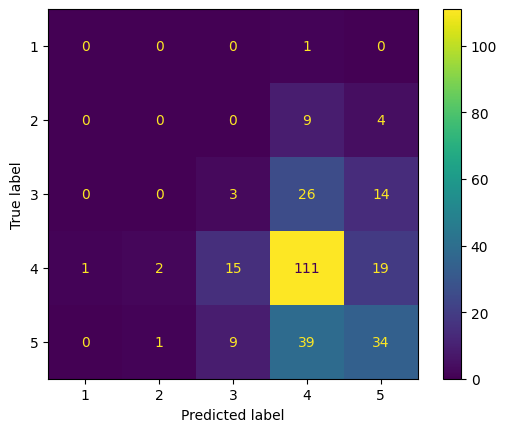

In [ ]:
get_metricas(y_test_ea, predicciones_rf, bosque.classes_)

In [ ]:
feature_names = df.columns[:-2]
features_importances = bosque.feature_importances_

In [ ]:
combined_lists = list(zip(feature_names, features_importances))
combined_lists = [elem for elem in combined_lists if elem[1] > 0]
feature_importance_list = sorted(combined_lists, key=lambda x: x[1], reverse=True)
feature_importance_list

[('Ocupación_aula', 0.09749646340204296),
 ('Cortinas_abiertas', 0.08709045178010452),
 ('LumINTMAX', 0.062227752035502196),
 ('LumINTMED', 0.06040981699341994),
 ('Ventanas_abiertas', 0.05964522590835272),
 ('LumINTMIN', 0.05376787990660804),
 ('Calefacción_enc', 0.051139794379933566),
 ('TempEXTHIC', 0.05103700408168976),
 ('HumEXTHFC', 0.04575629939904401),
 ('TempINTMIN', 0.045499710688988684),
 ('TempINTMAX', 0.04490313487332841),
 ('HumEXTHIC', 0.041117613844650736),
 ('TempEXTHFC', 0.04099184758107178),
 ('HumINTMIN', 0.04021155315468627),
 ('HumINTMAX', 0.040086376042185956),
 ('TempEXTMED', 0.03812020992755214),
 ('TempINTMED', 0.037130194157462965),
 ('HumINTMED', 0.036898054028731274),
 ('HumEXTMED', 0.029249229981915533),
 ('G_B_A', 0.018581134940644797),
 ('Luces_apagadas', 0.011934514863402839),
 ('Orientacion', 0.0035905748370874085),
 ('AACC_enc', 0.003115163191593547)]

#### Estado físico

In [ ]:
parametros_rf = {
    "n_estimators": [100, 500, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None],
}

In [ ]:
bosque = RandomForestClassifier(random_state=14, n_jobs=4)
rf_grid = GridSearchCV(bosque, parametros_rf, verbose=1, scoring="accuracy")

In [ ]:
rf_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=4, random_state=14),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 1000}

In [ ]:
bosque = RandomForestClassifier(**rf_grid.best_params_, random_state=14, n_jobs=4)
bosque.fit(X_train_ef, y_train_ef)

RandomForestClassifier(criterion='entropy', max_features=None,
                       n_estimators=1000, n_jobs=4, random_state=14)

In [ ]:
predicciones_rf = bosque.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5381944444444444
Precisión del modelo en el conjunto de test: 0.4784522328460636
Recall del modelo en el conjunto de test: 0.5381944444444444
F1 del modelo en el conjunto de test: 0.5003427087879859


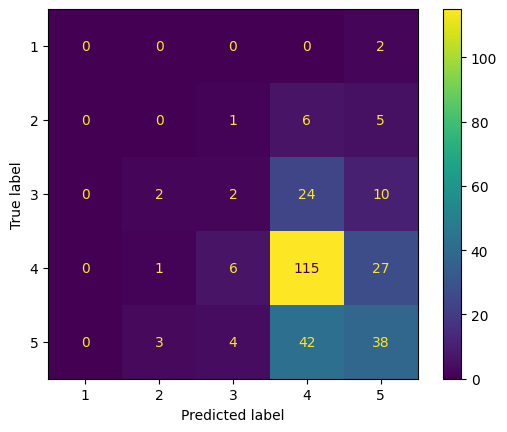

In [ ]:
get_metricas(y_test_ef, predicciones_rf, bosque.classes_)

In [ ]:
feature_names = df.columns[:-2]
features_importances = bosque.feature_importances_

In [ ]:
combined_lists = list(zip(feature_names, features_importances))
combined_lists = [elem for elem in combined_lists if elem[1] > 0]
feature_importance_list = sorted(combined_lists, key=lambda x: x[1], reverse=True)
feature_importance_list

[('Ocupación_aula', 0.10736994655860527),
 ('Cortinas_abiertas', 0.08700968846512201),
 ('LumINTMAX', 0.07115629690371268),
 ('LumINTMED', 0.06517185790328409),
 ('Ventanas_abiertas', 0.05699509067922572),
 ('LumINTMIN', 0.053738637581266464),
 ('TempEXTHIC', 0.049732708038584955),
 ('Calefacción_enc', 0.04940666652659306),
 ('HumINTMAX', 0.0469788262547334),
 ('HumINTMIN', 0.04493017251863867),
 ('TempINTMAX', 0.04181884263232752),
 ('HumEXTHFC', 0.03866602582237785),
 ('TempEXTHFC', 0.03842194209854916),
 ('TempINTMIN', 0.038397495957917256),
 ('HumINTMED', 0.037147197197896095),
 ('TempINTMED', 0.03671996616281823),
 ('HumEXTHIC', 0.03469313863678324),
 ('TempEXTMED', 0.03227874312214901),
 ('HumEXTMED', 0.027175861209578444),
 ('G_B_A', 0.021153638091538175),
 ('Luces_apagadas', 0.010680171613946026),
 ('Orientacion', 0.008007517363072583),
 ('AACC_enc', 0.0023495686612801897)]

### Gradient Boosting

#### Estado anímico

In [ ]:
parametros_gradientBoosting = {
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.1, 0.07, 0.05, 0.01],
    "n_estimators": [100, 250, 500, 1000],
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
gboost = GradientBoostingClassifier(random_state=14)
gb_grid = GridSearchCV(gboost, parametros_gradientBoosting, verbose=1, scoring="accuracy")

In [ ]:
gb_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=14),
             param_grid={'learning_rate': [0.1, 0.07, 0.05, 0.01],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
gb_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_features': None,
 'n_estimators': 100}

In [ ]:
gboost = GradientBoostingClassifier(**gb_grid.best_params_, random_state=14)
gboost.fit(X_train_ea, y_train_ea)

GradientBoostingClassifier(learning_rate=0.01, random_state=14)

In [ ]:
predicciones_gb = gboost.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.5729166666666666
Precisión del modelo en el conjunto de test: 0.4888068181818181
Recall del modelo en el conjunto de test: 0.5729166666666666
F1 del modelo en el conjunto de test: 0.49774598931365355


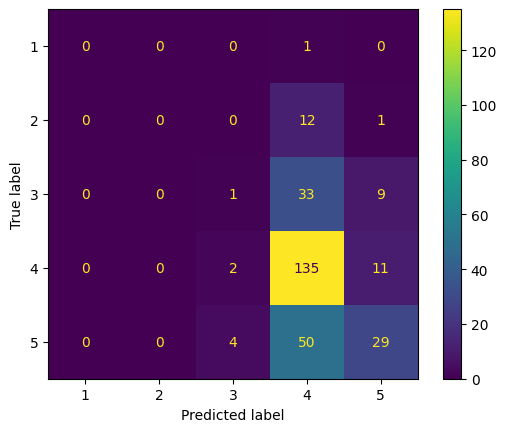

In [ ]:
get_metricas(y_test_ea, predicciones_gb, gboost.classes_)

#### Estado físico

In [ ]:
parametros_gradientBoosting = {
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.1, 0.07, 0.05, 0.01],
    "n_estimators": [100, 250, 500, 1000],
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
gboost = GradientBoostingClassifier(random_state=14)
gb_grid = GridSearchCV(gboost, parametros_gradientBoosting, verbose=1, scoring="accuracy")

In [ ]:
gb_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=14),
             param_grid={'learning_rate': [0.1, 0.07, 0.05, 0.01],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
gb_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_features': None,
 'n_estimators': 100}

In [ ]:
gboost = GradientBoostingClassifier(**gb_grid.best_params_, random_state=14)
gboost.fit(X_train_ef, y_train_ef)

GradientBoostingClassifier(learning_rate=0.01, random_state=14)

In [ ]:
predicciones_gb = gboost.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5694444444444444
Precisión del modelo en el conjunto de test: 0.4766019223067681
Recall del modelo en el conjunto de test: 0.5694444444444444
F1 del modelo en el conjunto de test: 0.4994037808410748


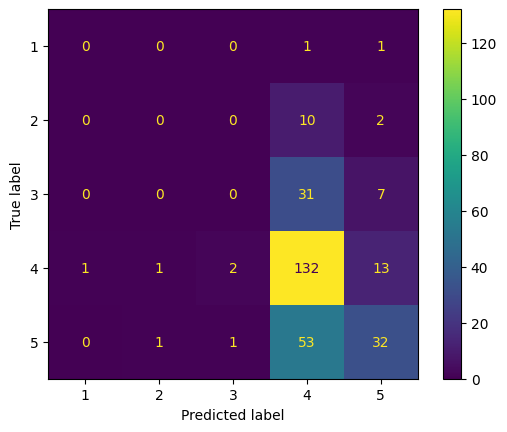

In [ ]:
get_metricas(y_test_ef, predicciones_gb, gboost.classes_)

### SVC

#### Estado anímico

In [ ]:
parametros_svc = {
    "kernel": ("linear", "poly", "rbf", "sigmoid"),
    "decision_function_shape": ("ovo", "ovr")
}

In [ ]:
svc = SVC(random_state=14)
svc_grid = GridSearchCV(svc, parametros_svc, verbose=1, scoring="accuracy")

In [ ]:
svc_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(random_state=14),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy', verbose=1)

In [ ]:
svc_grid.best_params_

{'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [ ]:
svc_grid.best_params_['probability']=True

In [ ]:
svc = SVC(**svc_grid.best_params_, random_state=14)
svc.fit(X_train_ea, y_train_ea)

SVC(decision_function_shape='ovo', probability=True, random_state=14)

In [ ]:
predicciones_svc = svc.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.6006944444444444
Precisión del modelo en el conjunto de test: 0.4998976923384038
Recall del modelo en el conjunto de test: 0.6006944444444444
F1 del modelo en el conjunto de test: 0.5145613860730139


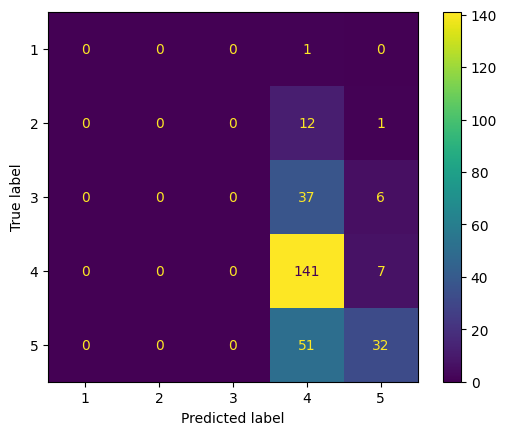

In [ ]:
get_metricas(y_test_ea, predicciones_svc, svc.classes_)

#### Estado físico

In [ ]:
parametros_svc = {
    "kernel": ("linear", "poly", "rbf", "sigmoid"),
    "decision_function_shape": ("ovo", "ovr"),
}

In [ ]:
svc = SVC(random_state=14)
svc_grid = GridSearchCV(svc, parametros_svc, verbose=1, scoring="accuracy")

In [ ]:
svc_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(random_state=14),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy', verbose=1)

In [ ]:
svc_grid.best_params_

{'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [ ]:
svc = SVC(**svc_grid.best_params_, random_state=14)
svc.fit(X_train_ef, y_train_ef)

SVC(decision_function_shape='ovo', random_state=14)

In [ ]:
predicciones_svc = svc.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5902777777777778
Precisión del modelo en el conjunto de test: 0.47818835997087117
Recall del modelo en el conjunto de test: 0.5902777777777778
F1 del modelo en el conjunto de test: 0.5158146261711627


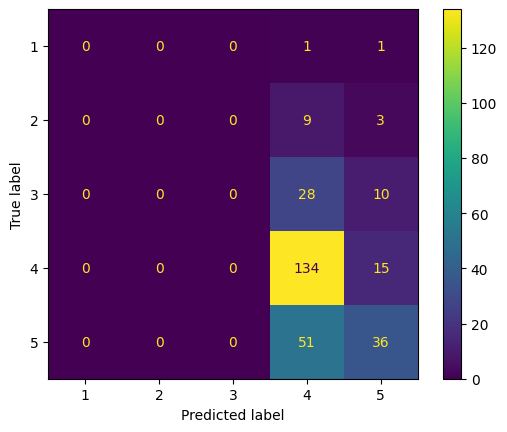

In [ ]:
get_metricas(y_test_ef, predicciones_svc, svc.classes_)

### Logistic Regression

#### Estado anímico

In [ ]:
parametros_logisticRegression = {
    "penalty": ["l2", None],
    "solver": ["lbfgs", "newton-cg", "sag", "saga"]
    }

In [ ]:
lg = LogisticRegression(random_state=14)
lg_grid = GridSearchCV(lg, parametros_logisticRegression, verbose=1, scoring="accuracy")

In [ ]:
lg_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(random_state=14),
             param_grid={'penalty': ['l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
lg_grid.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [ ]:
lg = LogisticRegression(**lg_grid.best_params_, random_state=14)
lg.fit(X_train_ea, y_train_ea)

LogisticRegression(random_state=14, solver='saga')

In [ ]:
predicciones_lg = lg.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.5729166666666666
Precisión del modelo en el conjunto de test: 0.4521768484970477
Recall del modelo en el conjunto de test: 0.5729166666666666
F1 del modelo en el conjunto de test: 0.5020567508664804


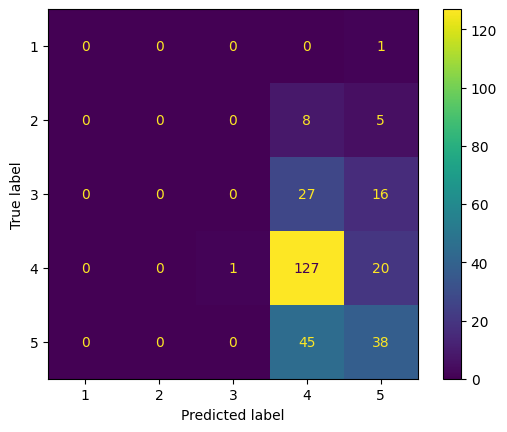

In [ ]:
get_metricas(y_test_ea, predicciones_lg, lg.classes_)

#### Estado físico

In [ ]:
parametros_logisticRegression = {
    "penalty": ["l2", None],
    "solver": ["lbfgs", "newton-cg", "sag", "saga"]
    }

In [ ]:
lg = LogisticRegression(random_state=14)
lg_grid = GridSearchCV(lg, parametros_logisticRegression, verbose=1, scoring="accuracy")

In [ ]:
lg_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(random_state=14),
             param_grid={'penalty': ['l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
lg_grid.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [ ]:
lg = LogisticRegression(**lg_grid.best_params_, random_state=14)
lg.fit(X_train_ef, y_train_ef)

LogisticRegression(random_state=14, solver='saga')

In [ ]:
predicciones_lg = lg.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5868055555555556
Precisión del modelo en el conjunto de test: 0.4725087648327939
Recall del modelo en el conjunto de test: 0.5868055555555556
F1 del modelo en el conjunto de test: 0.519655920400774


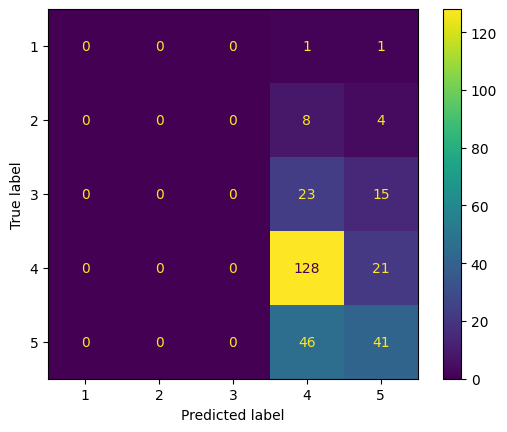

In [ ]:
get_metricas(y_test_ef, predicciones_lg, lg.classes_)

### KNNClassifier

#### Estado anímico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(5, 25, 5),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "brute", "ball_tree", "kd_tree"),
    "p": (1, 2, 3)
}

In [ ]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, parametros_knn, verbose=1, scoring="accuracy")

In [ ]:
knn_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'brute', 'ball_tree', 'kd_tree'),
                         'n_neighbors': array([ 5, 10, 15, 20]), 'p': (1, 2, 3),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=1)

In [ ]:
knn_grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 3, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**knn_grid.best_params_)
knn.fit(X_train_ea, y_train_ea)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=20, p=3)

In [ ]:
predicciones_knn = knn.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.625
Precisión del modelo en el conjunto de test: 0.5049683179723502
Recall del modelo en el conjunto de test: 0.625
F1 del modelo en el conjunto de test: 0.5496631300922196


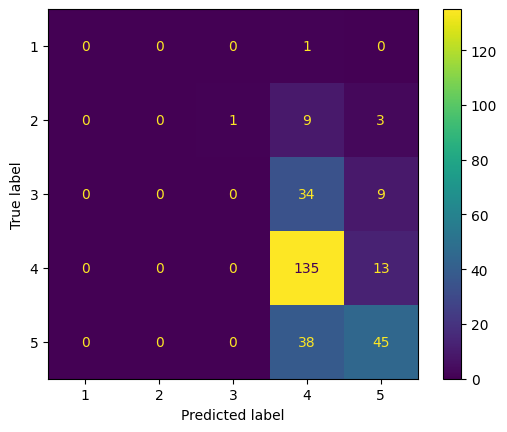

In [ ]:
get_metricas(y_test_ea, predicciones_knn, knn.classes_)

#### Estado físico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(5, 25, 5),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "brute", "ball_tree", "kd_tree"),
    "p": (1, 2, 3)
}

In [ ]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, parametros_knn, verbose=1, scoring="accuracy")

In [ ]:
knn_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'brute', 'ball_tree', 'kd_tree'),
                         'n_neighbors': array([ 5, 10, 15, 20]), 'p': (1, 2, 3),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=1)

In [ ]:
knn_grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**knn_grid.best_params_)
knn.fit(X_train_ef, y_train_ef)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=15)

In [ ]:
predicciones_knn = knn.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.6041666666666666
Precisión del modelo en el conjunto de test: 0.54827562203169
Recall del modelo en el conjunto de test: 0.6041666666666666
F1 del modelo en el conjunto de test: 0.5482195724450695


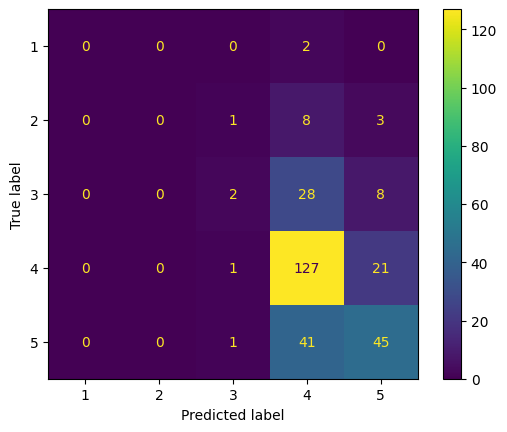

In [ ]:
get_metricas(y_test_ef, predicciones_knn, knn.classes_)

## Implementación del modelo: 3 clases de bienestar

La precisión máxima alcanzada por los modelos anteriores es de 0,6. Si tenemos en cuenta que existen 5 clases y el azar se correspondería con un accuracy de 0,2, la precisión obtenida por los modelos es aceptable. Sin embargo, un análisis más en profundidad revela que, puesto que el conjunto de datos de entrenamiento se encuentra completamente desbalanceado, los modelos aprenden a predecir las dos clases mayoritarias para acertar.

Para intentar solucionar este desbalance de clases, se agruparán los niveles de bienestar 1,2 y 3 en una nueva clase de no bienestar. De esta manera, se convierte el problema en un problema de clasificación ternaria con clases 5, 4 y no bienestar, que se representará con el nivel 0.

### Funciones auxiliares

In [ ]:
def get_metricas(y_true, y_pred, clases, plot_confusion_matrix=True):
  print(f"Accuracy del modelo en el conjunto de test: {accuracy_score(y_true, y_pred)}")
  print(f"Precisión del modelo en el conjunto de test: {precision_score(y_true, y_pred, average='weighted')}")
  print(f"Recall del modelo en el conjunto de test: {recall_score(y_true, y_pred, average='weighted')}")
  print(f"F1 del modelo en el conjunto de test: {f1_score(y_true, y_pred, average='weighted')}")

  if plot_confusion_matrix:
    cm = confusion_matrix(y_true, y_pred, labels=clases)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
    disp.plot()
    plt.show()

### Transformación de clases

In [ ]:
def asignar_clase(valor):
  clase = 0
  if valor == 5:
    clase = 5
  elif valor == 4:
    clase = 4

  return clase

In [ ]:
df['G_B_A'] = df['G_B_A'].apply(asignar_clase)
df['G_B_F'] = df['G_B_F'].apply(asignar_clase)

In [ ]:
conteo_clases = df['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    492
5    276
0    191
Name: count, dtype: int64


In [ ]:
conteo_clases = df['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    496
5    289
0    174
Name: count, dtype: int64


Tal y como puede observarse, el número de muestras por clase se encuentra más balanceado. Veamos como se comportan los modelos frente a esta nueva aprximación.

### División en train y test

#### Conjunto de datos para la predicción del bienestar anímico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_A']]

In [ ]:
X_train_ea, X_test_ea, y_train_ea, y_test_ea = train_test_split(X, y, test_size=0.3, random_state=14)

In [ ]:
X_train_ea.shape

(671, 23)

In [ ]:
y_train_ea.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    336
5    193
0    142
Name: count, dtype: int64


In [ ]:
X_test_ea.shape

(288, 23)

In [ ]:
y_test_ea.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    156
5     83
0     49
Name: count, dtype: int64


#### Conjunto de datos para la predicción del bienestar físico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_F']]

In [ ]:
X_train_ef, X_test_ef, y_train_ef, y_test_ef = train_test_split(X, y, test_size=0.3, random_state=14)

In [ ]:
X_train_ef.shape

(671, 23)

In [ ]:
y_train_ef.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    348
5    192
0    131
Name: count, dtype: int64


In [ ]:
X_test_ef.shape

(288, 23)

In [ ]:
y_test_ef.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    148
5     97
0     43
Name: count, dtype: int64


### Random Forest

#### Estado anímico

In [ ]:
parametros_rf = {
    "n_estimators": [100, 500, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None],
}

In [ ]:
bosque = RandomForestClassifier(random_state=14, n_jobs=4)
rf_grid = GridSearchCV(bosque, parametros_rf, verbose=1, scoring="accuracy")

In [ ]:
rf_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=4, random_state=14),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}

In [ ]:
bosque = RandomForestClassifier(**rf_grid.best_params_, random_state=14, n_jobs=4)
bosque.fit(X_train_ea, y_train_ea)

RandomForestClassifier(criterion='entropy', max_features=None, n_jobs=4,
                       random_state=14)

In [ ]:
predicciones_rf = bosque.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.5243055555555556
Precisión del modelo en el conjunto de test: 0.4896077653674339
Recall del modelo en el conjunto de test: 0.5243055555555556
F1 del modelo en el conjunto de test: 0.5037416803870505


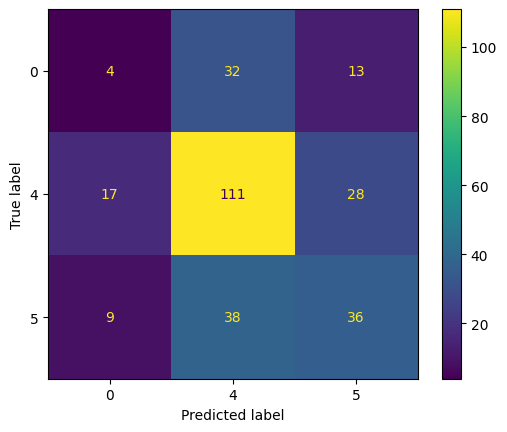

In [ ]:
get_metricas(y_test_ea, predicciones_rf, bosque.classes_)

In [ ]:
feature_names = df.columns[:-2]
features_importances = bosque.feature_importances_

In [ ]:
combined_lists = list(zip(feature_names, features_importances))
combined_lists = [elem for elem in combined_lists if elem[1] > 0]
feature_importance_list = sorted(combined_lists, key=lambda x: x[1], reverse=True)
feature_importance_list

[('Cortinas_abiertas', 0.10082497098448097),
 ('Ocupación_aula', 0.10030812693483916),
 ('HumINTMIN', 0.06350545079053332),
 ('LumINTMAX', 0.06069582972299709),
 ('Ventanas_abiertas', 0.05576747782968527),
 ('LumINTMED', 0.05532065342660368),
 ('Calefacción_enc', 0.05442813607649278),
 ('TempINTMAX', 0.04812793103495704),
 ('HumEXTHFC', 0.04753635853179154),
 ('HumINTMED', 0.04502143802357846),
 ('LumINTMIN', 0.044127173102212085),
 ('HumINTMAX', 0.043107549810104534),
 ('TempEXTHFC', 0.04235954451281365),
 ('TempEXTHIC', 0.0386408977481257),
 ('TempINTMIN', 0.03816342279047692),
 ('TempINTMED', 0.03475485265935507),
 ('HumEXTHIC', 0.03447298635187033),
 ('TempEXTMED', 0.03434390075082963),
 ('HumEXTMED', 0.026395736524522657),
 ('G_B_A', 0.02125383739291952),
 ('Luces_apagadas', 0.00757531261906057),
 ('Orientacion', 0.002512688496864109),
 ('AACC_enc', 0.0007557238848860666)]

#### Estado físico

In [ ]:
parametros_rf = {
    "n_estimators": [100, 500, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None],
}

In [ ]:
bosque = RandomForestClassifier(random_state=14, n_jobs=4)
rf_grid = GridSearchCV(bosque, parametros_rf, verbose=1, scoring="accuracy")

In [ ]:
rf_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=4, random_state=14),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}

In [ ]:
bosque = RandomForestClassifier(**rf_grid.best_params_, random_state=14, n_jobs=4)
bosque.fit(X_train_ef, y_train_ef)

RandomForestClassifier(criterion='entropy', max_features=None, n_jobs=4,
                       random_state=14)

In [ ]:
predicciones_rf = bosque.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5416666666666666
Precisión del modelo en el conjunto de test: 0.5285252386241086
Recall del modelo en el conjunto de test: 0.5416666666666666
F1 del modelo en el conjunto de test: 0.5286682181170924


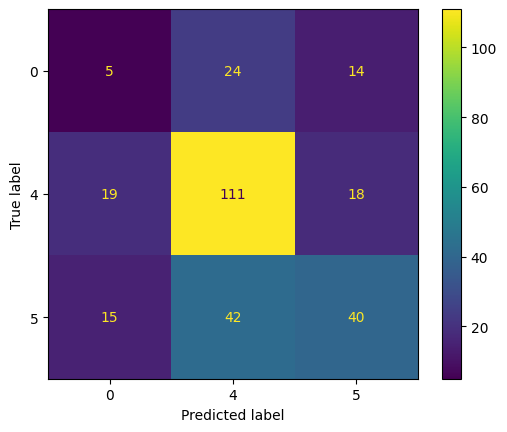

In [ ]:
get_metricas(y_test_ef, predicciones_rf, bosque.classes_)

In [ ]:
feature_names = df.columns[:-2]
features_importances = bosque.feature_importances_

In [ ]:
combined_lists = list(zip(feature_names, features_importances))
combined_lists = [elem for elem in combined_lists if elem[1] > 0]
feature_importance_list = sorted(combined_lists, key=lambda x: x[1], reverse=True)
feature_importance_list

[('Ocupación_aula', 0.10596380672313171),
 ('Cortinas_abiertas', 0.0960007740187109),
 ('LumINTMED', 0.06185935895566444),
 ('LumINTMAX', 0.05932337889774602),
 ('Ventanas_abiertas', 0.05676412313623858),
 ('LumINTMIN', 0.05514876743640462),
 ('Calefacción_enc', 0.05124302642981664),
 ('TempEXTHFC', 0.050247434319834146),
 ('HumINTMIN', 0.04783946175395116),
 ('HumINTMAX', 0.04616685115802771),
 ('TempINTMIN', 0.04346038120717965),
 ('TempEXTHIC', 0.04121712911431705),
 ('TempINTMAX', 0.040711399047005846),
 ('HumEXTHIC', 0.04012937572660486),
 ('HumINTMED', 0.038149145974509885),
 ('TempINTMED', 0.03679872102011723),
 ('HumEXTHFC', 0.03572077182430483),
 ('TempEXTMED', 0.03244766529455863),
 ('HumEXTMED', 0.03177331537467847),
 ('G_B_A', 0.019551982757669114),
 ('Luces_apagadas', 0.004661892793786197),
 ('Orientacion', 0.0028351816208664537),
 ('AACC_enc', 0.0019860554148759244)]

### Gradient Boosting

#### Estado anímico

In [ ]:
parametros_gradientBoosting = {
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.1, 0.07, 0.05, 0.01],
    "n_estimators": [100, 250, 500, 1000],
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
gboost = GradientBoostingClassifier(random_state=14)
gb_grid = GridSearchCV(gboost, parametros_gradientBoosting, verbose=1, scoring="accuracy")

In [ ]:
gb_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=14),
             param_grid={'learning_rate': [0.1, 0.07, 0.05, 0.01],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
gb_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_features': 'sqrt',
 'n_estimators': 250}

In [ ]:
gboost = GradientBoostingClassifier(**gb_grid.best_params_, random_state=14)
gboost.fit(X_train_ea, y_train_ea)

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           n_estimators=250, random_state=14)

In [ ]:
predicciones_gb = gboost.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.5833333333333334
Precisión del modelo en el conjunto de test: 0.5461914783636096
Recall del modelo en el conjunto de test: 0.5833333333333334
F1 del modelo en el conjunto de test: 0.52472810111699


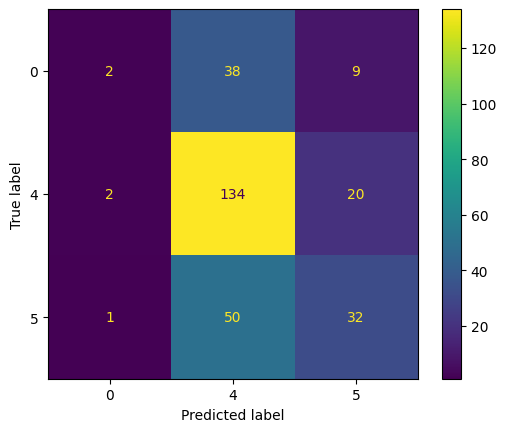

In [ ]:
get_metricas(y_test_ea, predicciones_gb, gboost.classes_)

#### Estado físico

In [ ]:
parametros_gradientBoosting = {
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.1, 0.07, 0.05, 0.01],
    "n_estimators": [100, 250, 500, 1000],
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
gboost = GradientBoostingClassifier(random_state=14)
gb_grid = GridSearchCV(gboost, parametros_gradientBoosting, verbose=1, scoring="accuracy")

In [ ]:
gb_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=14),
             param_grid={'learning_rate': [0.1, 0.07, 0.05, 0.01],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
gb_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
gboost = GradientBoostingClassifier(**gb_grid.best_params_, random_state=14)
gboost.fit(X_train_ef, y_train_ef)

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           random_state=14)

In [ ]:
predicciones_gb = gboost.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5694444444444444
Precisión del modelo en el conjunto de test: 0.49310565311395865
Recall del modelo en el conjunto de test: 0.5694444444444444
F1 del modelo en el conjunto de test: 0.48599827335514356


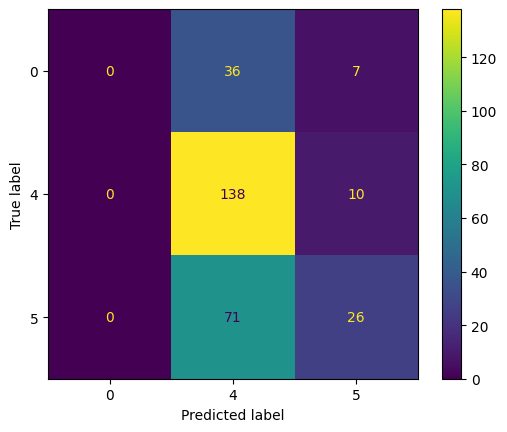

In [ ]:
get_metricas(y_test_ef, predicciones_gb, gboost.classes_)

### SVC

#### Estado anímico

In [ ]:
parametros_svc = {
    "kernel": ("linear", "poly", "rbf", "sigmoid"),
    "decision_function_shape": ("ovo", "ovr")
}

In [ ]:
svc = SVC(random_state=14)
svc_grid = GridSearchCV(svc, parametros_svc, verbose=1, scoring="accuracy")

In [ ]:
svc_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(random_state=14),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy', verbose=1)

In [ ]:
svc_grid.best_params_

{'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [ ]:
svc_grid.best_params_['probability']=True

In [ ]:
svc = SVC(**svc_grid.best_params_, random_state=14)
svc.fit(X_train_ea, y_train_ea)

SVC(decision_function_shape='ovo', probability=True, random_state=14)

In [ ]:
predicciones_svc = svc.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.6041666666666666
Precisión del modelo en el conjunto de test: 0.4983400341130605
Recall del modelo en el conjunto de test: 0.6041666666666666
F1 del modelo en el conjunto de test: 0.5332183007964258


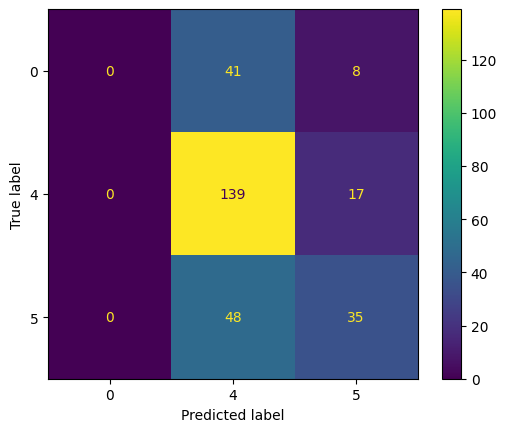

In [ ]:
get_metricas(y_test_ea, predicciones_svc, svc.classes_)

#### Estado físico

In [ ]:
parametros_svc = {
    "kernel": ("linear", "poly", "rbf", "sigmoid"),
    "decision_function_shape": ("ovo", "ovr"),
}

In [ ]:
svc = SVC(random_state=14)
svc_grid = GridSearchCV(svc, parametros_svc, verbose=1, scoring="accuracy")

In [ ]:
svc_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(random_state=14),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy', verbose=1)

In [ ]:
svc_grid.best_params_

{'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [ ]:
svc = SVC(**svc_grid.best_params_, random_state=14)
svc.fit(X_train_ef, y_train_ef)

SVC(decision_function_shape='ovo', random_state=14)

In [ ]:
predicciones_svc = svc.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.6145833333333334
Precisión del modelo en el conjunto de test: 0.6769798101889157
Recall del modelo en el conjunto de test: 0.6145833333333334
F1 del modelo en el conjunto de test: 0.5560801876622722


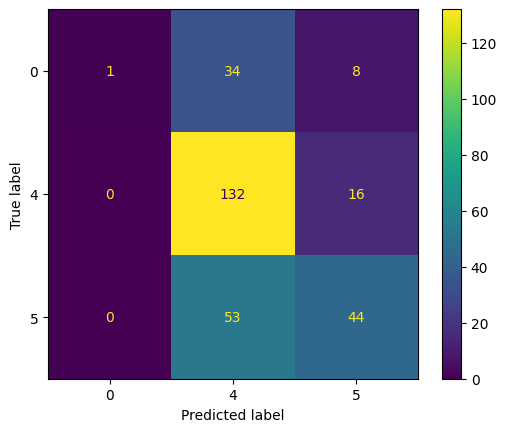

In [ ]:
get_metricas(y_test_ef, predicciones_svc, svc.classes_)

### Logistic Regression

#### Estado anímico

In [ ]:
parametros_logisticRegression = {
    "penalty": ["l2", None],
    "solver": ["lbfgs", "newton-cg", "sag", "saga"]
    }

In [ ]:
lg = LogisticRegression(random_state=14)
lg_grid = GridSearchCV(lg, parametros_logisticRegression, verbose=1, scoring="accuracy")

In [ ]:
lg_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(random_state=14),
             param_grid={'penalty': ['l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
lg_grid.best_params_

{'penalty': 'l2', 'solver': 'sag'}

In [ ]:
lg = LogisticRegression(**lg_grid.best_params_, random_state=14)
lg.fit(X_train_ea, y_train_ea)

LogisticRegression(random_state=14, solver='sag')

In [ ]:
predicciones_lg = lg.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.6041666666666666
Precisión del modelo en el conjunto de test: 0.49338988705799314
Recall del modelo en el conjunto de test: 0.6041666666666666
F1 del modelo en el conjunto de test: 0.5360829678362573


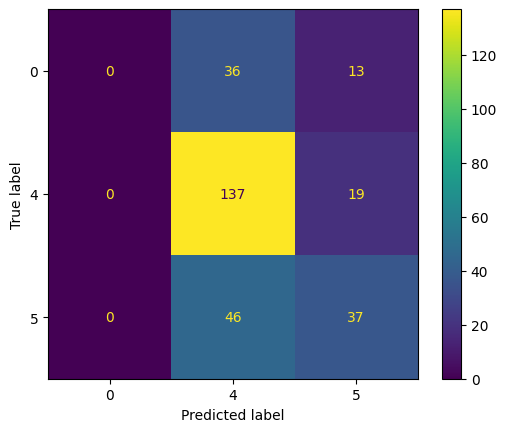

In [ ]:
get_metricas(y_test_ea, predicciones_lg, lg.classes_)

#### Estado físico

In [ ]:
parametros_logisticRegression = {
    "penalty": ["l2", None],
    "solver": ["lbfgs", "newton-cg", "sag", "saga"]
    }

In [ ]:
lg = LogisticRegression(random_state=14)
lg_grid = GridSearchCV(lg, parametros_logisticRegression, verbose=1, scoring="accuracy")

In [ ]:
lg_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(random_state=14),
             param_grid={'penalty': ['l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy', verbose=1)

In [ ]:
lg_grid.best_params_

{'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
lg = LogisticRegression(**lg_grid.best_params_, random_state=14)
lg.fit(X_train_ef, y_train_ef)

LogisticRegression(random_state=14)

In [ ]:
predicciones_lg = lg.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.5972222222222222
Precisión del modelo en el conjunto de test: 0.5107280320667387
Recall del modelo en el conjunto de test: 0.5972222222222222
F1 del modelo en el conjunto de test: 0.5398347028336402


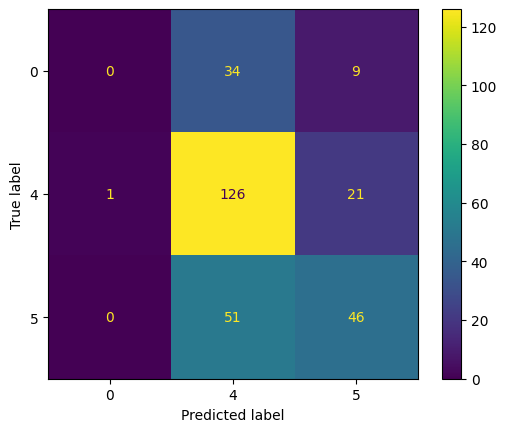

In [ ]:
get_metricas(y_test_ef, predicciones_lg, lg.classes_)

### KNNClassifier

#### Estado anímico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(5, 25, 5),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "brute", "ball_tree", "kd_tree"),
    "p": (1, 2, 3)
}

In [ ]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, parametros_knn, verbose=1, scoring="accuracy")

In [ ]:
knn_grid.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'brute', 'ball_tree', 'kd_tree'),
                         'n_neighbors': array([ 5, 10, 15, 20]), 'p': (1, 2, 3),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=1)

In [ ]:
knn_grid.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**knn_grid.best_params_)
knn.fit(X_train_ea, y_train_ea)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, p=1)

In [ ]:
predicciones_knn = knn.predict(X_test_ea)

Accuracy del modelo en el conjunto de test: 0.6076388888888888
Precisión del modelo en el conjunto de test: 0.5339053242679446
Recall del modelo en el conjunto de test: 0.6076388888888888
F1 del modelo en el conjunto de test: 0.5596235668601081


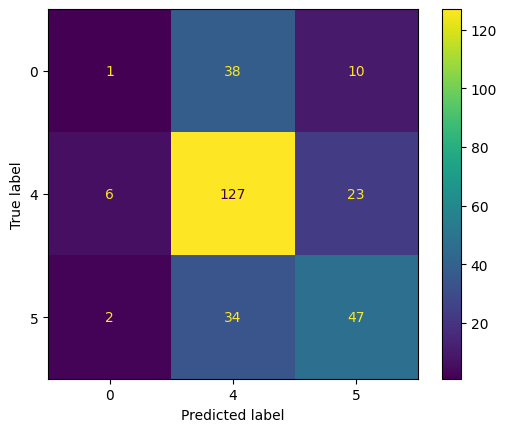

In [ ]:
get_metricas(y_test_ea, predicciones_knn, knn.classes_)

#### Estado físico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(5, 25, 5),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "brute", "ball_tree", "kd_tree"),
    "p": (1, 2, 3)
}

In [ ]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, parametros_knn, verbose=1, scoring="accuracy")

In [ ]:
knn_grid.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'brute', 'ball_tree', 'kd_tree'),
                         'n_neighbors': array([ 5, 10, 15, 20]), 'p': (1, 2, 3),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=1)

In [ ]:
knn_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**knn_grid.best_params_)
knn.fit(X_train_ef, y_train_ef)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
predicciones_knn = knn.predict(X_test_ef)

Accuracy del modelo en el conjunto de test: 0.6354166666666666
Precisión del modelo en el conjunto de test: 0.6085391189568458
Recall del modelo en el conjunto de test: 0.6354166666666666
F1 del modelo en el conjunto de test: 0.6055065080580373


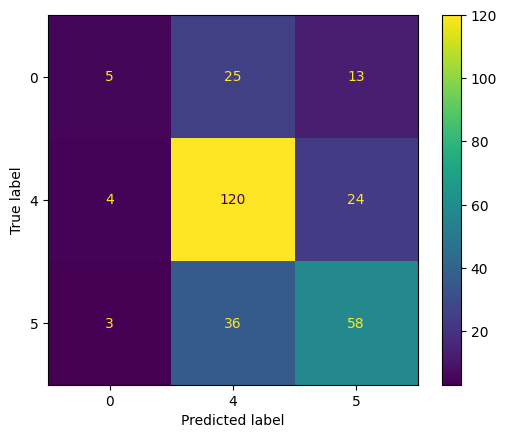

In [ ]:
get_metricas(y_test_ef, predicciones_knn, knn.classes_)

## Implementación del modelo: problema de regresión

### División en train y test

#### Conjunto de datos para la predicción del bienestar anímico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_A']]

In [ ]:
X_train_ea, X_test_ea, y_train_ea, y_test_ea = train_test_split(X, y, test_size=0.3, random_state=14)

In [ ]:
X_train_ea.shape

(671, 23)

In [ ]:
y_train_ea.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    336
5    193
3    103
2     35
1      4
Name: count, dtype: int64


In [ ]:
X_test_ea.shape

(288, 23)

In [ ]:
y_test_ea.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ea['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    156
5     83
3     39
2      9
1      1
Name: count, dtype: int64


#### Conjunto de datos para la predicción del bienestar físico

In [ ]:
X = df.drop(['G_B_A', 'G_B_F'], axis=1)
y = df[['G_B_F']]

In [ ]:
X_train_ef, X_test_ef, y_train_ef, y_test_ef = train_test_split(X, y, test_size=0.3, random_state=14)

In [ ]:
X_train_ef.shape

(671, 23)

In [ ]:
y_train_ef.shape

(671, 1)

In [ ]:
conteo_clases = y_train_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    348
5    192
3     98
2     27
1      6
Name: count, dtype: int64


In [ ]:
X_test_ef.shape

(288, 23)

In [ ]:
y_test_ef.shape

(288, 1)

In [ ]:
conteo_clases = y_test_ef['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    148
5     97
3     28
2     15
Name: count, dtype: int64


### Random Forest

#### Estado anímico

In [ ]:
parametros_randomforest={
    "n_estimators": (100 , 250, 500, 1000),
    "criterion": ("squared_error", "absolute_error", "friedman_mse", "poisson"),
    "max_features": ("auto", "sqrt", "log2")
    }

randomForest = RandomForestRegressor(random_state=14)
gs_randomforest = GridSearchCV(randomForest, parametros_randomforest, verbose=1, n_jobs=32, cv=5, scoring="r2", error_score=0)

In [ ]:
gs_randomforest.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, error_score=0,
             estimator=RandomForestRegressor(random_state=14), n_jobs=32,
             param_grid={'criterion': ('squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': (100, 250, 500, 1000)},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_rf = gs_randomforest.best_params_
mejores_parametros_rf

{'criterion': 'absolute_error', 'max_features': 'sqrt', 'n_estimators': 250}

In [ ]:
randomforest= RandomForestRegressor(**mejores_parametros_rf, random_state=14, n_jobs=4)
randomforest.fit(X_train_ea, y_train_ea)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=250, n_jobs=4, random_state=14)

In [ ]:
predicciones_RF = randomforest.predict(X_test_ea)

In [ ]:
mae = mean_absolute_error(y_test_ea, predicciones_RF)
print(f'MAE: {mae}')

MAE: 0.6137916666666666


In [ ]:
mse = mean_squared_error(y_test_ea, predicciones_RF)
print(f'MSE: {mse}')

MSE: 0.6775568333333334


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.8231384047250702


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.4930555555555556
Precisión del modelo en el conjunto de test: 0.39440514842300556
Recall del modelo en el conjunto de test: 0.4930555555555556
F1 del modelo en el conjunto de test: 0.4049514523875496


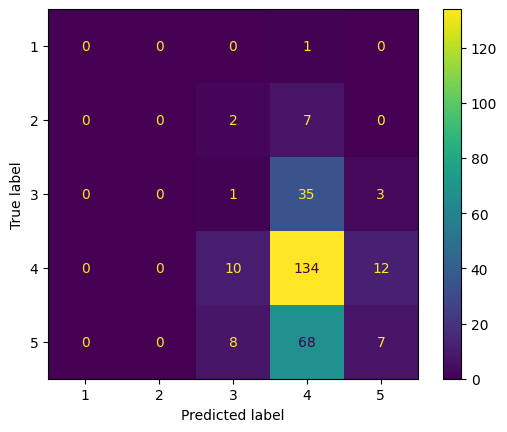

In [ ]:
ped_rf_cl = np.round(predicciones_RF)
classes = np.arange(1, 6)
get_metricas(y_test_ea, ped_rf_cl, classes)

#### Estado físico

In [ ]:
parametros_randomforest={
    "n_estimators": (100 , 250, 500, 1000),
    "criterion": ("squared_error", "absolute_error", "friedman_mse", "poisson"),
    "max_features": ("auto", "sqrt", "log2")
    }

randomForest = RandomForestRegressor(random_state=14)
gs_randomforest = GridSearchCV(randomForest, parametros_randomforest, verbose=1, n_jobs=32, cv=5, scoring="r2", error_score=0)

In [ ]:
gs_randomforest.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, error_score=0,
             estimator=RandomForestRegressor(random_state=14), n_jobs=32,
             param_grid={'criterion': ('squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': (100, 250, 500, 1000)},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_rf = gs_randomforest.best_params_
mejores_parametros_rf

{'criterion': 'absolute_error', 'max_features': 'sqrt', 'n_estimators': 500}

In [ ]:
randomforest= RandomForestRegressor(**mejores_parametros_rf, random_state=14, n_jobs=4)
randomforest.fit(X_train_ef, y_train_ef)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=500, n_jobs=4, random_state=14)

In [ ]:
predicciones_RF = randomforest.predict(X_test_ef)

In [ ]:
mae = mean_absolute_error(y_test_ef, predicciones_RF)
print(f'MAE: {mae}')

MAE: 0.6320416666666666


In [ ]:
mse = mean_squared_error(y_test_ef, predicciones_RF)
print(f'MSE: {mse}')

MSE: 0.7290928125


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.8538693181629142


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.4895833333333333
Precisión del modelo en el conjunto de test: 0.41218817265516144
Recall del modelo en el conjunto de test: 0.4895833333333333
F1 del modelo en el conjunto de test: 0.3996231342778657


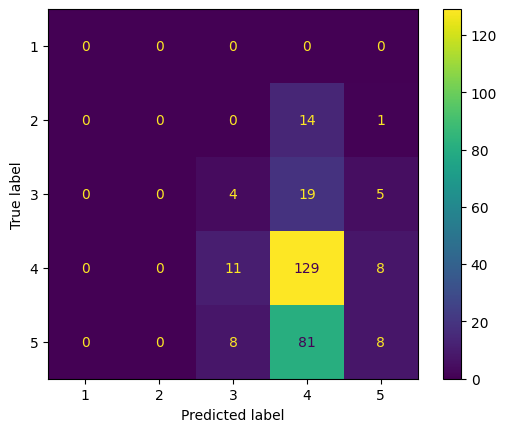

In [ ]:
ped_rf_cl = np.round(predicciones_RF)
classes = np.arange(1, 6)
get_metricas(y_test_ef, ped_rf_cl, classes)

### Gradient Boosting

#### Estado anímico

In [ ]:
parametros_gbr = {
    "loss": ("squared_error", "ls", "absolute_error", "lad", "huber", "quantile"),
    "learning_rate": (0.1,0.05,0.01),
    "criterion": ("friedman_mse", "squared_error", "mse", "absolute_error")
}

gradientRegressor = GradientBoostingRegressor(random_state=14)
gs_gradientRegressor = GridSearchCV(gradientRegressor, parametros_gbr, verbose=1, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_gradientRegressor.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=14),
             n_jobs=32,
             param_grid={'criterion': ('friedman_mse', 'squared_error', 'mse',
                                       'absolute_error'),
                         'learning_rate': (0.1, 0.05, 0.01),
                         'loss': ('squared_error', 'ls', 'absolute_error',
                                  'lad', 'huber', 'quantile')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_gbr = gs_gradientRegressor.best_params_
mejores_parametros_gbr

{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'huber'}

In [ ]:
gradientRegressor = GradientBoostingRegressor(**mejores_parametros_gbr, random_state=14)
gradientRegressor.fit(X_train_ea, y_train_ea)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', random_state=14)

In [ ]:
predicciones_gbr = gradientRegressor.predict(X_test_ea)

In [ ]:
mae = mean_absolute_error(y_test_ea, predicciones_gbr)
print(f'MAE: {mae}')

MAE: 0.5054453040897479


In [ ]:
mse = mean_squared_error(y_test_ea, predicciones_gbr)
print(f'MSE: {mse}')

MSE: 0.5427116736114991


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7366896725294166


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5416666666666666
Precisión del modelo en el conjunto de test: 0.2934027777777778
Recall del modelo en el conjunto de test: 0.5416666666666666
F1 del modelo en el conjunto de test: 0.38063063063063063


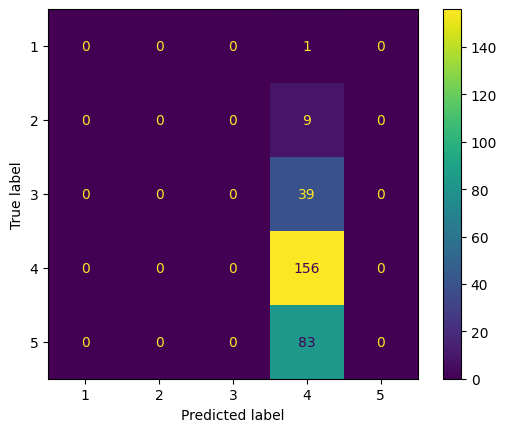

In [ ]:
ped_gb_cl = np.round(predicciones_gbr)
classes = np.arange(1, 6)
get_metricas(y_test_ea, ped_gb_cl, classes)

#### Estado físico

In [ ]:
parametros_gbr = {
    "loss": ("squared_error", "ls", "absolute_error", "lad", "huber", "quantile"),
    "learning_rate": (0.1,0.05,0.01),
    "criterion": ("friedman_mse", "squared_error", "mse", "absolute_error")
}

gradientRegressor = GradientBoostingRegressor(random_state=14)
gs_gradientRegressor = GridSearchCV(gradientRegressor, parametros_gbr, verbose=1, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_gradientRegressor.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=14),
             n_jobs=32,
             param_grid={'criterion': ('friedman_mse', 'squared_error', 'mse',
                                       'absolute_error'),
                         'learning_rate': (0.1, 0.05, 0.01),
                         'loss': ('squared_error', 'ls', 'absolute_error',
                                  'lad', 'huber', 'quantile')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_gbr = gs_gradientRegressor.best_params_
mejores_parametros_gbr

{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'huber'}

In [ ]:
gradientRegressor = GradientBoostingRegressor(**mejores_parametros_gbr, random_state=14)
gradientRegressor.fit(X_train_ef, y_train_ef)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', random_state=14)

In [ ]:
predicciones_gbr = gradientRegressor.predict(X_test_ef)

In [ ]:
mae = mean_absolute_error(y_test_ef, predicciones_gbr)
print(f'MAE: {mae}')

MAE: 0.5457865908357068


In [ ]:
mse = mean_squared_error(y_test_ef, predicciones_gbr)
print(f'MSE: {mse}')

MSE: 0.5969492766796383


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7726249262608852


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5138888888888888
Precisión del modelo en el conjunto de test: 0.26408179012345673
Recall del modelo en el conjunto de test: 0.5138888888888888
F1 del modelo en el conjunto de test: 0.3488786952089704


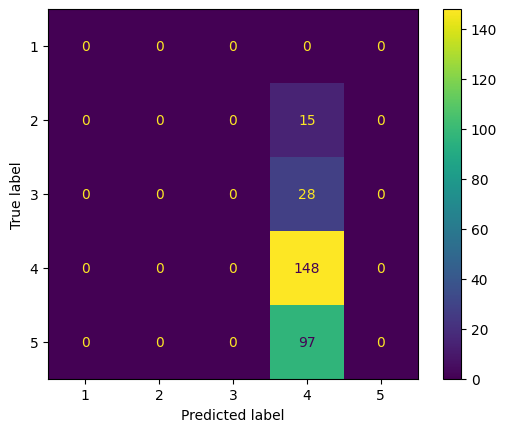

In [ ]:
ped_gb_cl = np.round(predicciones_gbr)
classes = np.arange(1, 6)
get_metricas(y_test_ef, ped_gb_cl, classes)

### SVR

#### Estado anímico

In [ ]:
parametros_svr = {
    "kernel": ("linear", "poly", "rbf", "sigmoid")
}
svr = SVR()
gs_svr = GridSearchCV(svr, parametros_svr, verbose=1, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_svr.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=32,
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_svr = gs_svr.best_params_
mejores_parametros_svr

{'kernel': 'rbf'}

In [ ]:
svr = SVR(**mejores_parametros_svr)
svr.fit(X_train_ea, y_train_ea)

SVR()

In [ ]:
predicciones_svr = svr.predict(X_test_ea)

In [ ]:
mae = mean_absolute_error(y_test_ea, predicciones_svr)
print(f'MAE: {mae}')

MAE: 0.5027182423658844


In [ ]:
mse = mean_squared_error(y_test_ea, predicciones_svr)
print(f'MSE: {mse}')

MSE: 0.5312629395320199


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.728877863247348


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5833333333333334
Precisión del modelo en el conjunto de test: 0.5080563624971519
Recall del modelo en el conjunto de test: 0.5833333333333334
F1 del modelo en el conjunto de test: 0.47511378168961105


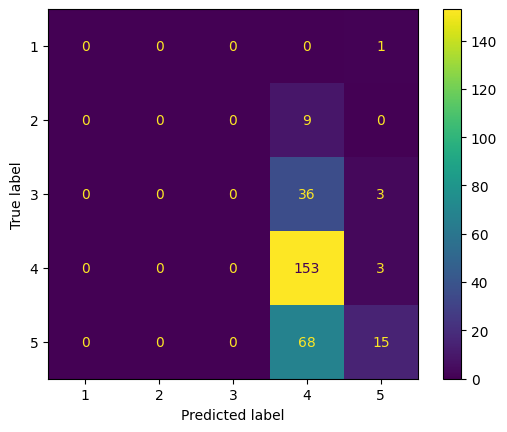

In [ ]:
ped_svr_cl = np.round(predicciones_svr)
classes = np.arange(1, 6)
get_metricas(y_test_ea, ped_svr_cl, classes)

#### Estado físico

In [ ]:
parametros_svr = {
    "kernel": ("linear", "poly", "rbf", "sigmoid")
}
svr = SVR()
gs_svr = GridSearchCV(svr, parametros_svr, verbose=1, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_svr.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=32,
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_svr = gs_svr.best_params_
mejores_parametros_svr

{'kernel': 'rbf'}

In [ ]:
svr = SVR(**mejores_parametros_svr)
svr.fit(X_train_ef, y_train_ef)

SVR()

In [ ]:
predicciones_svr = svr.predict(X_test_ef)

In [ ]:
mae = mean_absolute_error(y_test_ef, predicciones_svr)
print(f'MAE: {mae}')

MAE: 0.5304921812321557


In [ ]:
mse = mean_squared_error(y_test_ef, predicciones_svr)
print(f'MSE: {mse}')

MSE: 0.5801719128790784


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.761690168558764


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5555555555555556
Precisión del modelo en el conjunto de test: 0.49692437684833124
Recall del modelo en el conjunto de test: 0.5555555555555556
F1 del modelo en el conjunto de test: 0.44843976440243044


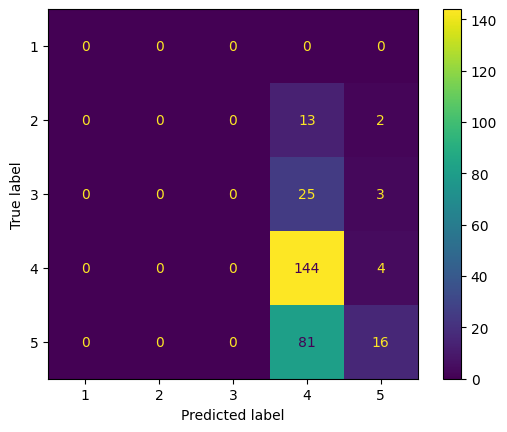

In [ ]:
ped_svr_cl = np.round(predicciones_svr)
np.max(ped_svr_cl)
classes = np.arange(1, 6)
get_metricas(y_test_ef, ped_svr_cl, classes)

### KNN

#### Estado anímico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(3, 10, 1),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "ball_tree", "kd_tree", "brute"),
    "metric": ("euclidean", "manhattan", "chebyshev")
}
knn = KNeighborsRegressor()
gs_knn = GridSearchCV(knn, parametros_knn, verbose=2, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_knn.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=32,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'metric': ('euclidean', 'manhattan', 'chebyshev'),
                         'n_neighbors': array([3, 4, 5, 6, 7, 8, 9]),
                         'weights': ('uniform', 'distance')},
             scoring='r2', verbose=2)

In [ ]:
mejores_parametros_knn = gs_knn.best_params_
mejores_parametros_knn

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 9,
 'weights': 'uniform'}

In [ ]:
knn = KNeighborsRegressor(**mejores_parametros_knn)
knn.fit(X_train_ea, y_train_ea)

KNeighborsRegressor(metric='manhattan', n_neighbors=9)

In [ ]:
predicciones_knn = knn.predict(X_test_ea)

In [ ]:
mae = mean_absolute_error(y_test_ea, predicciones_knn)
print(f'MAE: {mae}')

MAE: 0.544753086419753


In [ ]:
mse = mean_squared_error(y_test_ea, predicciones_knn)
print(f'MSE: {mse}')

MSE: 0.5442386831275721


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7377253439645218


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5694444444444444
Precisión del modelo en el conjunto de test: 0.5489328541070344
Recall del modelo en el conjunto de test: 0.5694444444444444
F1 del modelo en el conjunto de test: 0.5040058278139552


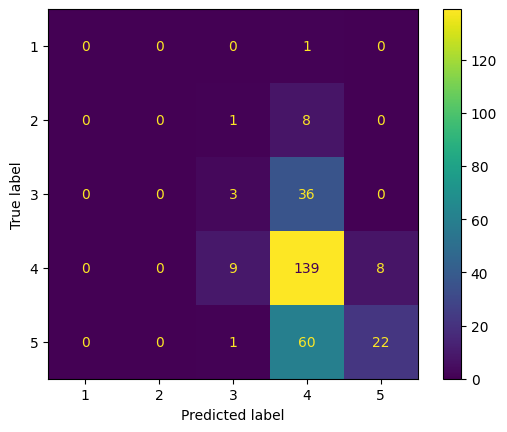

In [ ]:
ped_knn_cl = np.round(predicciones_knn)
classes = np.arange(1, 6)
get_metricas(y_test_ea, ped_knn_cl, classes)

#### Estado físico

In [ ]:
parametros_knn = {
    "n_neighbors": np.arange(3, 10, 1),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "ball_tree", "kd_tree", "brute"),
    "metric": ("euclidean", "manhattan", "chebyshev")
}
knn = KNeighborsRegressor()
gs_knn = GridSearchCV(knn, parametros_knn, verbose=2, n_jobs=32, cv=5, scoring="r2")

In [ ]:
gs_knn.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=32,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'metric': ('euclidean', 'manhattan', 'chebyshev'),
                         'n_neighbors': array([3, 4, 5, 6, 7, 8, 9]),
                         'weights': ('uniform', 'distance')},
             scoring='r2', verbose=2)

In [ ]:
mejores_parametros_knn = gs_knn.best_params_
mejores_parametros_knn

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 9,
 'weights': 'uniform'}

In [ ]:
knn = KNeighborsRegressor(**mejores_parametros_knn)
knn.fit(X_train_ef, y_train_ef)

KNeighborsRegressor(algorithm='ball_tree', metric='manhattan', n_neighbors=9)

In [ ]:
predicciones_knn = knn.predict(X_test_ef)

In [ ]:
mae = mean_absolute_error(y_test_ef, predicciones_knn)
print(f'MAE: {mae}')

MAE: 0.5744598765432098


In [ ]:
mse = mean_squared_error(y_test_ef, predicciones_knn)
print(f'MSE: {mse}')

MSE: 0.6069530178326475


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7790718951628582


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5381944444444444
Precisión del modelo en el conjunto de test: 0.5286328841582465
Recall del modelo en el conjunto de test: 0.5381944444444444
F1 del modelo en el conjunto de test: 0.4513137985546522


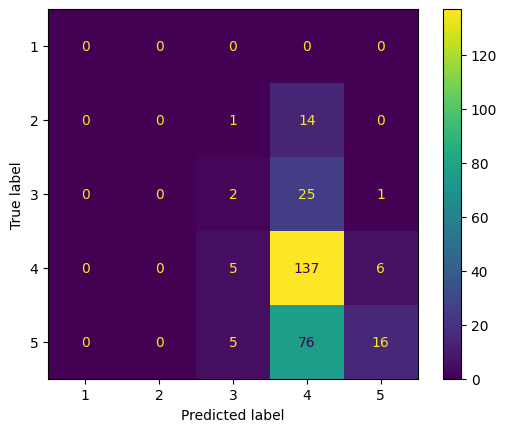

In [ ]:
ped_knn_cl = np.round(predicciones_knn)
classes = np.arange(1, 6)
get_metricas(y_test_ef, ped_knn_cl, classes)

### SGDRegressor

#### Estado anímico

In [ ]:
parametros_sgdreg = {
    "loss": ("squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"),
    "penalty": ("l1", "l2", "elasticnet"),
    "learning_rate": ("constant", "optimal", "adaptive", "invscaling")
    }

sgdreg = SGDRegressor(random_state=20, early_stopping=True)
gs_sgdreg = GridSearchCV(sgdreg, parametros_sgdreg, verbose=1, n_jobs=32, cv=5, scoring="r2", error_score=0)

In [ ]:
gs_sgdreg.fit(X_train_ea, y_train_ea)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, error_score=0,
             estimator=SGDRegressor(early_stopping=True, random_state=20),
             n_jobs=32,
             param_grid={'learning_rate': ('constant', 'optimal', 'adaptive',
                                           'invscaling'),
                         'loss': ('squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_sgdreg = gs_sgdreg.best_params_
mejores_parametros_sgdreg

{'learning_rate': 'adaptive',
 'loss': 'squared_epsilon_insensitive',
 'penalty': 'l1'}

In [ ]:
sgdr = SGDRegressor(**mejores_parametros_sgdreg, random_state=14)
sgdr.fit(X_train_ea, y_train_ea)

SGDRegressor(learning_rate='adaptive', loss='squared_epsilon_insensitive',
             penalty='l1', random_state=14)

In [ ]:
predicciones_sgdr = sgdr.predict(X_test_ea)

In [ ]:
mae = mean_absolute_error(y_test_ea, predicciones_sgdr)
print(f'MAE: {mae}')

MAE: 0.5580512587249077


In [ ]:
mse = mean_squared_error(y_test_ea, predicciones_sgdr)
print(f'MSE: {mse}')

MSE: 0.5649463636682177


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7516291397146718


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5381944444444444
Precisión del modelo en el conjunto de test: 0.49377042483660133
Recall del modelo en el conjunto de test: 0.5381944444444444
F1 del modelo en el conjunto de test: 0.41457387506552357


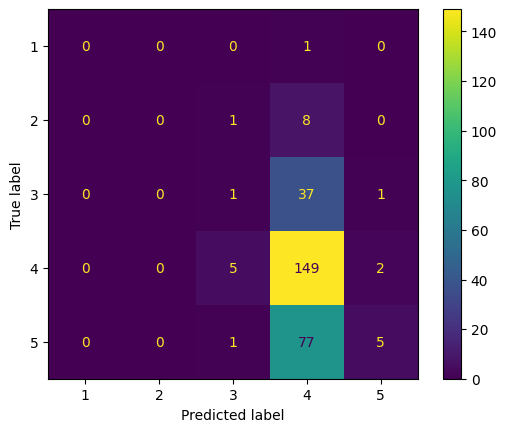

In [ ]:
ped_sgdr_cl = np.round(predicciones_sgdr)
classes = np.arange(1, 6)
get_metricas(y_test_ea, ped_sgdr_cl, classes)

#### Estado físico

In [ ]:
parametros_sgdreg = {
    "loss": ("squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"),
    "penalty": ("l1", "l2", "elasticnet"),
    "learning_rate": ("constant", "optimal", "adaptive", "invscaling")
    }

sgdreg = SGDRegressor(random_state=20, early_stopping=True)
gs_sgdreg = GridSearchCV(sgdreg, parametros_sgdreg, verbose=1, n_jobs=32, cv=5, scoring="r2", error_score=0)

In [ ]:
gs_sgdreg.fit(X_train_ef, y_train_ef)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, error_score=0,
             estimator=SGDRegressor(early_stopping=True, random_state=20),
             n_jobs=32,
             param_grid={'learning_rate': ('constant', 'optimal', 'adaptive',
                                           'invscaling'),
                         'loss': ('squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             scoring='r2', verbose=1)

In [ ]:
mejores_parametros_sgdreg = gs_sgdreg.best_params_
mejores_parametros_sgdreg

{'learning_rate': 'adaptive', 'loss': 'squared_error', 'penalty': 'l2'}

In [ ]:
sgdr = SGDRegressor(**mejores_parametros_sgdreg, random_state=14)
sgdr.fit(X_train_ef, y_train_ef)

SGDRegressor(learning_rate='adaptive', random_state=14)

In [ ]:
predicciones_sgdr = sgdr.predict(X_test_ef)

In [ ]:
mae = mean_absolute_error(y_test_ef, predicciones_sgdr)
print(f'MAE: {mae}')

MAE: 0.5849742375214562


In [ ]:
mse = mean_squared_error(y_test_ef, predicciones_sgdr)
print(f'MSE: {mse}')

MSE: 0.5912086154659204


In [ ]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.7689009139453018


De regresión a clasificación

Accuracy del modelo en el conjunto de test: 0.5
Precisión del modelo en el conjunto de test: 0.4275454483787817
Recall del modelo en el conjunto de test: 0.5
F1 del modelo en el conjunto de test: 0.37047579754350535


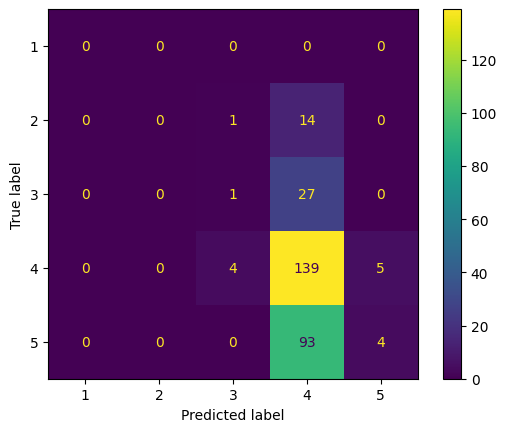

In [ ]:
ped_sgdr_cl = np.round(predicciones_sgdr)
classes = np.arange(1, 6)
get_metricas(y_test_ef, ped_sgdr_cl, classes)

## Entrenamiento final del mejor modelo

En relación con los resultados obtenidos anteriormente, el modelo que se empleará para la inferencia de nuevas muestras será el algoritmo de KNNC con la tercera aproximación. Se entrenará por última vez este modelo con la totalidad del conjunto de datos disponibles para generar los modelos finales de predicción.

### Transformación de clases

In [ ]:
def asignar_clase(valor):
  clase = 0
  if valor == 5:
    clase = 5
  elif valor == 4:
    clase = 4

  return clase

In [ ]:
df['G_B_A'] = df['G_B_A'].apply(asignar_clase)
df['G_B_F'] = df['G_B_F'].apply(asignar_clase)

In [ ]:
conteo_clases = df['G_B_A'].value_counts()
print(conteo_clases)

G_B_A
4    492
5    276
0    191
Name: count, dtype: int64


In [ ]:
conteo_clases = df['G_B_F'].value_counts()
print(conteo_clases)

G_B_F
4    496
5    289
0    174
Name: count, dtype: int64


Tal y como puede observarse, el número de muestras por clase se encuentra más balanceado. Veamos como se comportan los modelos frente a esta nueva aprximación.

In [ ]:
df.head(3)

,Orientacion,Luces_apagadas,Cortinas_abiertas,AACC_enc,Calefacción_enc,Ventanas_abiertas,Ocupación_aula,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,LumINTMIN,LumINTMAX,LumINTMED,HumINTMIN,HumINTMAX,HumINTMED,G_B_A,G_B_F,FH
0,4,0,5,0,0,2,2,0.116751,0.117347,0.057895,0.8875,0.898734,0.936709,0.703168,0.459386,0.767542,0.738265,0.596201,0.678865,0.350685,0.296649,0.316975,5,4,1
1,4,0,5,0,0,2,2,0.116751,0.127551,0.147368,0.9375,0.962025,0.873418,0.902834,0.505031,0.890321,0.757800,0.687376,0.777946,0.342266,0.290493,0.308282,5,4,2
2,4,0,5,0,0,2,2,0.203046,0.301020,0.326316,0.8750,0.721519,0.645570,0.966589,0.536339,0.944204,0.738536,0.939368,0.752936,0.325978,0.286955,0.301057,5,4,3


### KNNClassifier

In [ ]:
X_train_ea = df.drop(['G_B_A', 'G_B_F'], axis=1)
y_train_ea = df[['G_B_A']]

In [ ]:
X_train_ef = df.drop(['G_B_A', 'G_B_F'], axis=1)
y_train_ef = df[['G_B_F']]

#### Estado anímico

In [ ]:
mejores_parámetros = {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**mejores_parámetros)
knn.fit(X_train_ea, y_train_ea)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, p=1)

In [ ]:
with open('knnc_ba.pkl', 'wb') as f:
    pickle.dump(knn, f)

#### Estado físico

In [ ]:
mejores_parámetros = {'algorithm': 'auto', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(**mejores_parámetros)
knn.fit(X_train_ef, y_train_ef)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
with open('knnc_bf.pkl', 'wb') as f:
    pickle.dump(knn, f)